# Import packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp2d

# Lever Task

#### Create environment

In [3]:
class environment:

    def __init__(self, rewards, transition_probability = 0.5):
        assert len(rewards) == 3 and len(rewards[0]) == 3 and len(rewards[1]) == 2 and len(rewards[2]) == 2
        self.rewards = rewards
        self.tp = transition_probability
        self.reset()
    
    def reset(self):
        self.u = 1
        self.actions = [0, 1, 2]
    
    def step(self, action):
        assert action in self.actions
        reward = self.rewards[self.u-1][action] # determine reward

        # determine if task is terminated or not
        if self.u == 1 and action == 1:
            terminated = False
            self.u = np.random.choice([2, 3], p=[self.tp, 1-self.tp])
            self.actions = [0, 1]
        else:
            terminated = True
            self.reset()
        
        return reward, terminated


In [11]:
# test the environment

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 100000
rewards = np.zeros(n_trials)
for trial in range(n_trials):
    terminated = False
    while not terminated:
        r, terminated = env.step(np.random.choice(env.actions))
        rewards[trial] += r

print(rewards.mean())

1.00687


### Policy Evaluation

#### Define agent class

In [4]:
class policy_eval_agent:

    def __init__(self, lr):
        self.lr = lr
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4) # make 4 entries: empty state 0 (for when trial is terminated) and states 1-3
    
    def eval_policy(self, u, u_prime, reward):
        delta = reward + self.v[u_prime] - self.v[u]
        self.v[u] += self.lr * delta
        return delta

#### Learn predictions

In [13]:
a = policy_eval_agent(0.2)

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 1000
repetitions = 1000
prediction_history = np.zeros((3, repetitions, n_trials+1))
for i in range(repetitions):
    for trial in range(n_trials):
        prediction_history[:,i,trial] = a.v[1:]
        terminated = False
        while not terminated:
            u = env.u
            reward, terminated = env.step(np.random.choice(env.actions))
            u_prime = env.u if not terminated else 0
            a.eval_policy(u, u_prime, reward)
    prediction_history[:,i,n_trials] = a.v[1:]
    a.reset()

#### Plot

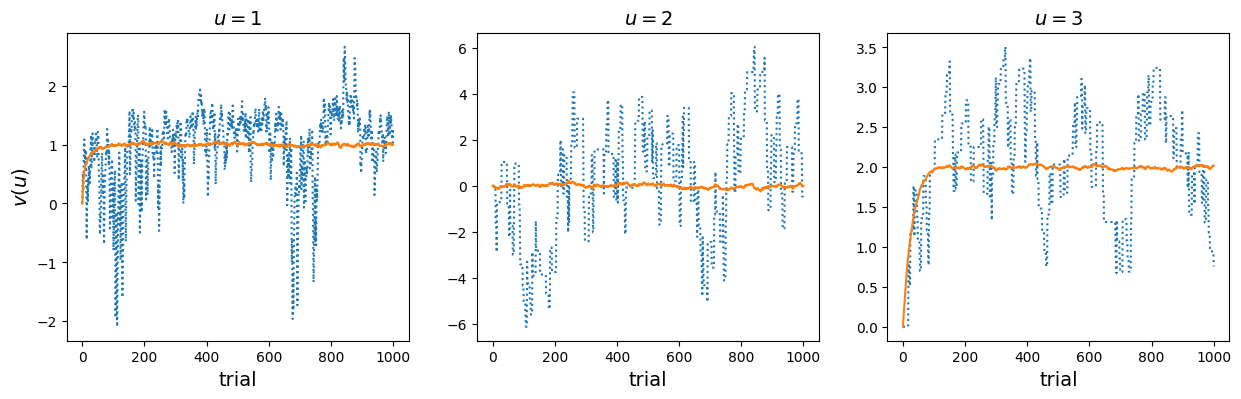

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for u in range(3):
    axs[u].set_title(f"$u = {u+1:d}$", fontsize=14)
    axs[u].plot(range(n_trials+1), prediction_history[u,0,:], ":")
    axs[u].plot(range(n_trials+1), prediction_history[u,:,:].mean(axis=0), "-")
    axs[u].set_xlabel("trial", fontsize=14)
axs[0].set_ylabel("$v(u)$", fontsize=14)
plt.show()


# Actor critic learning

#### Define agent class

In [5]:
class actor_critic_agent(policy_eval_agent):

    def __init__(self, lr, decay, lr_a, beta):
        self.lr = lr
        self.lr_a = lr_a
        self.decay = decay
        self.beta = beta
        self.reset()
    
    def reset(self):
        self.v = np.zeros(4)
        self.m = {1: np.zeros(3), 2: np.zeros(2), 3: np.zeros(2)}
    
    def update_actor(self, u, u_prime, reward, action):
        delta = self.eval_policy(u, u_prime, reward)
        for i in range(len(self.m[u])):
            self.m[u][i] = (1 - self.decay) * self.m[u][i]
            self.m[u][i] += self.lr_a * delta if action == i else 0
    
    def choose_action(self, env):
        u = env.u
        mv = self.m[u]
        assert len(mv) == len(env.actions)
        pv = np.exp(self.beta*mv)
        pv /= pv.sum()
        action = np.random.choice(env.actions, p=pv)
        return action

#### Train agent

In [12]:
a = actor_critic_agent(0.02, 0, 0.0075, 10)

env = environment([[1, -1, 2], [8, -8], [0, 4]])

n_trials = 200
repetitions = 1000
prediction_history = np.zeros((3, repetitions, n_trials+1))
m_history = {1: np.zeros((3, repetitions, n_trials+1)), 2: np.zeros((2, repetitions, n_trials+1)), 3: np.zeros((2, repetitions, n_trials+1))}
for i in range(repetitions):
    for trial in range(n_trials):
        prediction_history[:,i,trial] = a.v[1:]
        for state in range(1,4):
            m_history[state][:,i,trial] = a.m[state].copy()
        terminated = False
        while not terminated:
            u = env.u
            action = a.choose_action(env)
            reward, terminated = env.step(action)
            u_prime = env.u if not terminated else 0
            a.update_actor(u, u_prime, reward, action)
    prediction_history[:,i,n_trials] = a.v[1:]
    for state in range(1,4):
        m_history[state][:,i,n_trials] = a.m[state].copy()
    a.reset()

#### Plot results

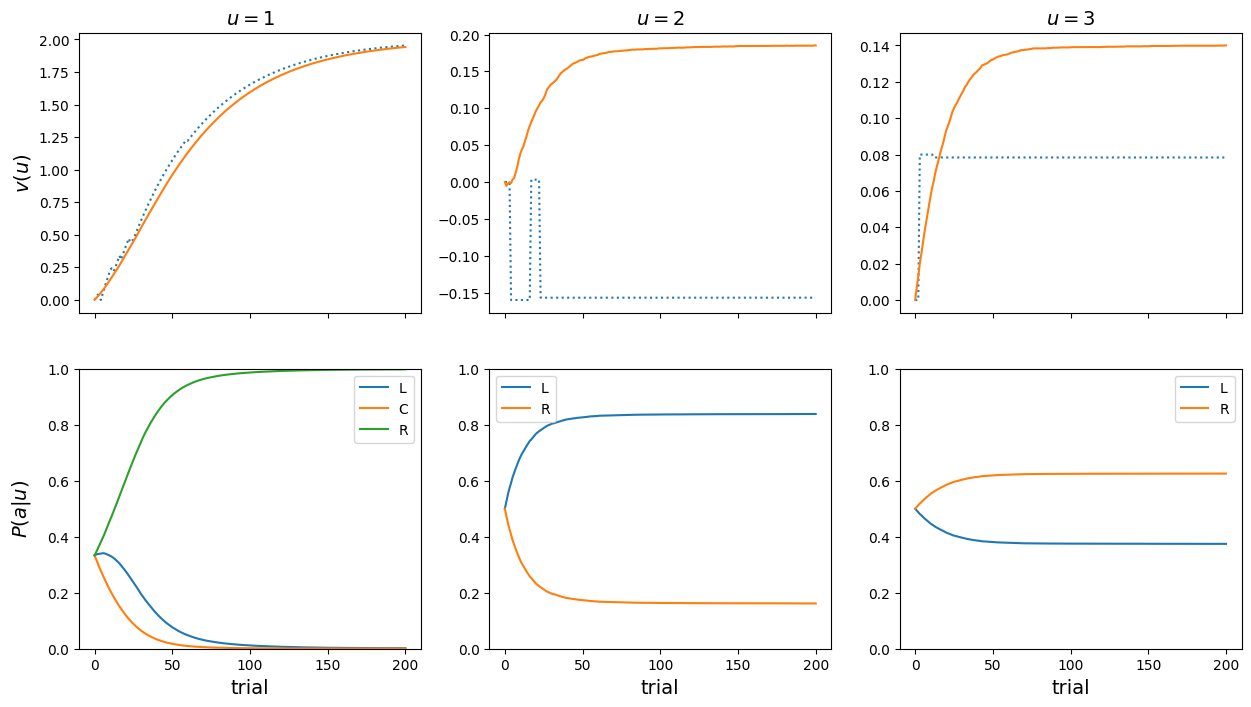

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)
for i in range(3):
    axs[0,i].set_title(f"$u = {i+1:d}$", fontsize=14)
    axs[0,i].plot(range(n_trials+1), prediction_history[i,2,:], ":")
    axs[0,i].plot(range(n_trials+1), prediction_history[i,:,:].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)
for i in range(3):
    mv = m_history[i+1]
    pv = np.exp(a.beta*mv) / np.sum(np.exp(a.beta*mv), axis=0)
    for j in range(pv.shape[0]):
        #axs[1,i].plot(range(n_trials+1), pv[j,0,:], ":")
        if i == 0:
            label = ["L", "C", "R"]
        else:
            label = ["L", "R"]
        axs[1,i].plot(range(n_trials+1), pv[j,:,:].mean(axis=0), "-", label = label[j])
        axs[1,i].set_xlabel("trial", fontsize=14)
        axs[1,i].set_ylim(0,1)
        axs[1,i].legend(loc=0)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()

#### Get average reward in dependence of learning rates

In [87]:
def compute_average_reward(agent, env):
    # u = 1
    pv1 = np.exp(agent.beta*agent.m[1])
    pv1 /= pv1.sum()
    # u = 2
    pv2 = np.exp(agent.beta*agent.m[2])
    pv2 /= pv2.sum()
    # u = 3
    pv3 = np.exp(agent.beta*agent.m[3])
    pv3 /= pv3.sum()
    # calculate average reward
    reward_center = 0.5 * ( (pv2 * np.array(env.rewards[1])).sum() + (pv3 * np.array(env.rewards[2])).sum() )
    reward = ( (np.array(env.rewards[0]) + np.array([0, reward_center, 0])) * pv1 ).sum()
    return reward

def simulate_average_reward(lr, decay, lr_a, beta, n_trials = 1000, repetitions = 50):
    a = actor_critic_agent(lr, decay, lr_a, beta)
    env = environment([[1, -1, 2], [8, -8], [0, 4]])
    avrg_reward = 0
    for i in range(repetitions):
        for trial in range(n_trials):
            terminated = False
            while not terminated:
                u = env.u
                try:
                    action = a.choose_action(env)
                except ValueError:
                    break
                reward, terminated = env.step(action)
                u_prime = env.u if not terminated else 0
                a.update_actor(u, u_prime, reward, action)
        avrg_reward += compute_average_reward(a, env)
        a.reset()
    avrg_reward /= (i+1)
    return avrg_reward

lr = np.logspace(-1.5, 0.3, 20)
lr_a = np.logspace(-3, -0.2, 20)
lr, lr_a = np.meshgrid(lr, lr_a)

reward = np.zeros(lr.shape)
for i, epsilon in enumerate(lr[0,:]):
    for j, epsilon_a in enumerate(lr_a[:,0]):
        reward[j,i] = simulate_average_reward(epsilon, 0, epsilon_a, 1, repetitions=100)

In [ ]:
pickle.dump(reward, open("avrg_reward_decay=0_beta=1.p", "wb"))

In [ ]:
reward = pickle.load(open("avrg_reward_decay=0_beta=1.p", "rb"))

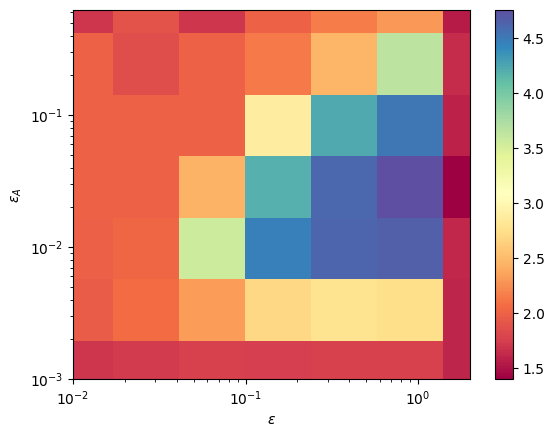

In [85]:
# interpolate for smooth plot
f = interp2d(lr, lr_a, reward, kind="cubic")
lr, lr_a = np.logspace(lr.min(), lr.max(), 300), np.logspace(lr_a.min(), lr_a.max(), 300)
reward = f(lr, lr_a)

# plot
fig, ax = plt.subplots()
im = ax.pcolor(lr, lr_a, reward, cmap="Spectral")
cbar = fig.colorbar(im)
cbar.set_label(r"$\langle r \rangle$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(lr.min(),lr.max())
ax.set_ylim(lr_a.min(),lr_a.max())
ax.set_xlabel("$\epsilon$")
ax.set_ylabel("$\epsilon_A$")
plt.show()

# Maze Task

#### Create Maze class

In [6]:
class maze_env:

    def __init__(self, rewards):
        self.rewards = np.array(rewards)
        self.reset()
    
    def reset(self):
        self.u = 0
        self.actions = [0, 1]
    
    def step(self, action):
        assert action in self.actions
        reward = self.rewards[self.u,action] # determine reward

        # determine if task is terminated or not
        if self.u < (self.rewards.shape[0] + 1) / 2 - 1:
            terminated = False
            self.u = 2 * self.u + action + 1
        else:
            terminated = True
            self.reset()
        
        return reward, terminated

#### Create maze agent

In [7]:
class maze_agent(policy_eval_agent):

    def __init__(self, lr, decay, lr_a, beta, total_possible_actions = 3):
        self.tpa = total_possible_actions
        self.lr = lr
        self.lr_a = lr_a
        self.decay = decay
        self.beta = beta
        self.reset()
    
    def reset(self):
        self.v = np.zeros(self.tpa+1) # one extra state for when trial is terminated
        self.m = np.zeros((self.tpa, 2))
    
    def update_actor(self, u, u_prime, reward, action):
        delta = self.eval_policy(u, u_prime, reward)
        for i in range(len(self.m[u,:])):
            self.m[u,i] = (1 - self.decay) * self.m[u,i]
            self.m[u,i] += self.lr_a * delta if action == i else 0
    
    def choose_action(self, env):
        u = env.u
        mv = self.m[u,:]
        assert len(mv) == len(env.actions)
        pv = np.exp(self.beta*mv)
        pv /= pv.sum()
        action = np.random.choice(env.actions, p=pv)
        return action

#### Train agent on maze task

In [85]:
a = maze_agent(0.2, 0, 0.075, 1)

reward_list = [[0, 0], [2, 3], [0, 4]]
maze = maze_env(reward_list)

n_trials = 1000
repetitions = 1000
prediction_history = np.zeros((repetitions, n_trials+1, len(reward_list)))
m_history = np.zeros((repetitions, n_trials+1, len(reward_list), 2))
for i in range(repetitions):
    for trial in range(n_trials):
        prediction_history[i,trial,:] = a.v[:-1]
        for state in range(len(reward_list)):
            m_history[i,trial,state,:] = a.m[state].copy()
        terminated = False
        while not terminated:
            u = maze.u
            action = a.choose_action(maze)
            reward, terminated = maze.step(action)
            u_prime = maze.u if not terminated else len(reward_list)#
            a.update_actor(u, u_prime, reward, action)
    prediction_history[i,n_trials,:] = a.v[:-1]
    for state in range(len(reward_list)):
        m_history[i,n_trials,state,:] = a.m[state].copy()
    a.reset()

#### Plot results

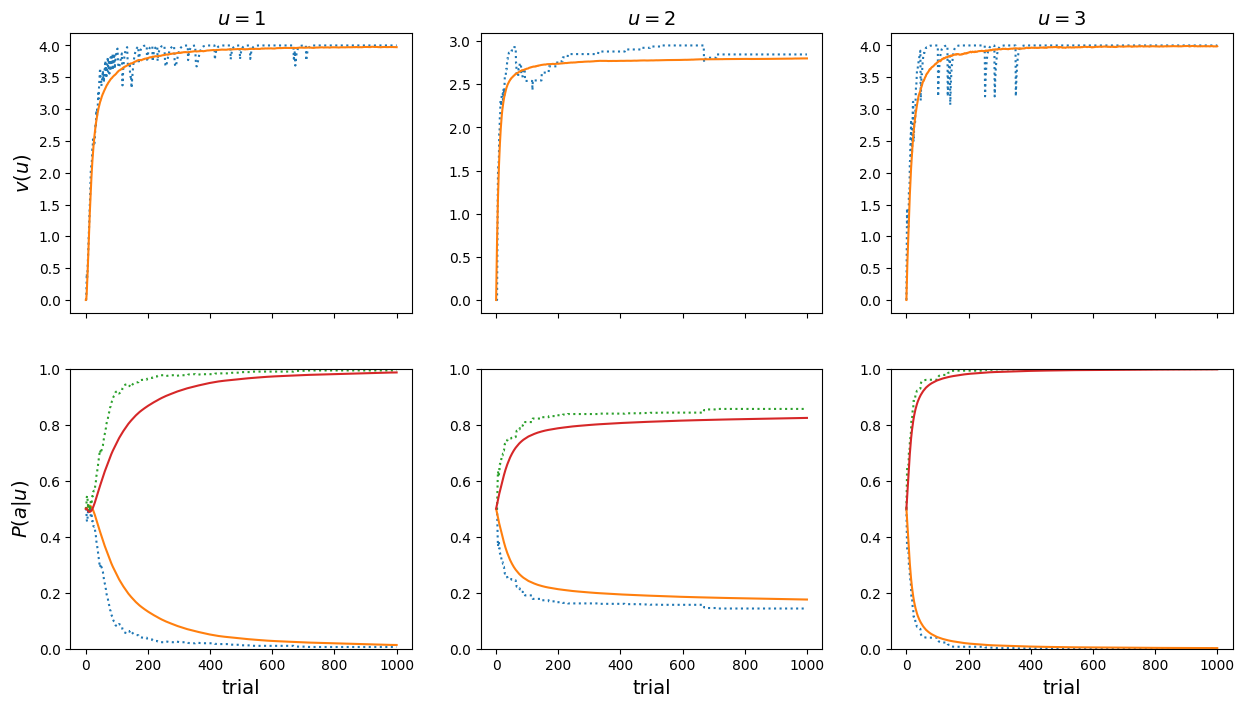

In [86]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)
for i in range(3):
    axs[0,i].set_title(f"$u = {i+1:d}$", fontsize=14)
    axs[0,i].plot(range(n_trials+1), prediction_history[0,:,i], ":")
    axs[0,i].plot(range(n_trials+1), prediction_history[:,:,i].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)
for i in range(3):
    mv = m_history[:,:,i,:]
    pv = np.exp(mv) / np.exp(mv).sum(axis=2).reshape(*mv.shape[:2],1)
    for j in range(pv.shape[2]):
        axs[1,i].plot(range(n_trials+1), pv[0,:,j], ":")
        axs[1,i].plot(range(n_trials+1), pv[:,:,j].mean(axis=0), "-")
        axs[1,i].set_xlabel("trial", fontsize=14)
        axs[1,i].set_ylim(0,1)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()

In [30]:
a = maze_agent(0.2, 0, 0.075, 1)

reward_list = [[1, -1], [2, 3], [0, 8]]
maze = maze_env(reward_list)

n_trials = 1000
repetitions = 100
flip = 200
prediction_history = np.zeros((repetitions, n_trials+1, len(reward_list)))
m_history = np.zeros((repetitions, n_trials+1, len(reward_list), 2))
for i in range(repetitions):
    maze.rewards = np.array([r[::-1] for r in reward_list])
    for trial in range(n_trials):
        if trial % flip == 0:
            maze.rewards = np.array([r[::-1] for r in maze.rewards])
        prediction_history[i,trial,:] = a.v[:-1]
        for state in range(len(reward_list)):
            m_history[i,trial,state,:] = a.m[state].copy()
        terminated = False
        while not terminated:
            u = maze.u
            action = a.choose_action(maze)
            reward, terminated = maze.step(action)
            u_prime = maze.u if not terminated else len(reward_list)#
            a.update_actor(u, u_prime, reward, action)
    prediction_history[i,n_trials,:] = a.v[:-1]
    for state in range(len(reward_list)):
        m_history[i,n_trials,state,:] = a.m[state].copy()
    a.reset()

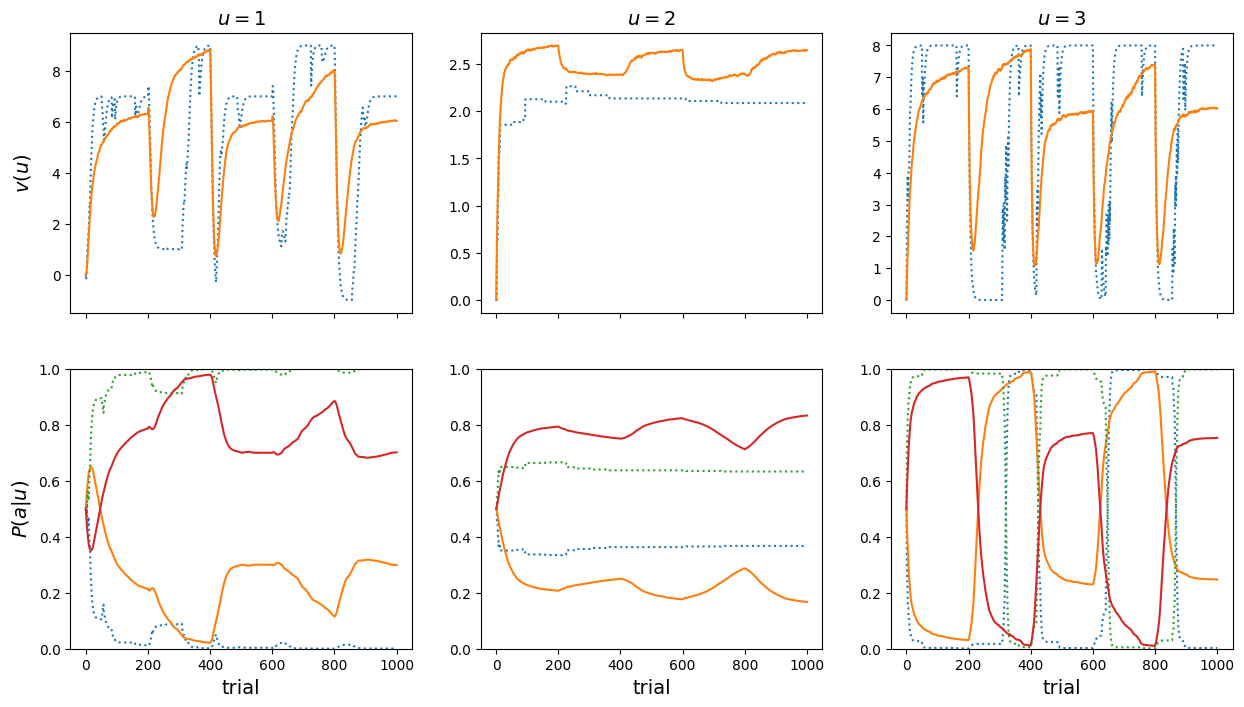

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex=True)
for i in range(3):
    axs[0,i].set_title(f"$u = {i+1:d}$", fontsize=14)
    axs[0,i].plot(range(n_trials+1), prediction_history[0,:,i], ":")
    axs[0,i].plot(range(n_trials+1), prediction_history[:,:,i].mean(axis=0), "-")
axs[0,0].set_ylabel("$v(u)$", fontsize=14)
for i in range(3):
    mv = m_history[:,:,i,:]
    pv = np.exp(mv) / np.exp(mv).sum(axis=2).reshape(*mv.shape[:2],1)
    for j in range(pv.shape[2]):
        axs[1,i].plot(range(n_trials+1), pv[0,:,j], ":")
        axs[1,i].plot(range(n_trials+1), pv[:,:,j].mean(axis=0), "-")
        axs[1,i].set_xlabel("trial", fontsize=14)
        axs[1,i].set_ylim(0,1)
axs[1,0].set_ylabel("$P(a|u)$", fontsize=14)
fig.align_ylabels(axs)
plt.show()